In [1]:
import gymnasium as gym
from gymnasium.wrappers import NumpyToTorch, DtypeObservation, RecordVideo
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
import torch as T
from torch import nn
from torch.optim import Adam
from torch.distributions import Normal, TransformedDistribution, AffineTransform, TanhTransform, Distribution

In [2]:
device = T.device("cuda" if T.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
env = gym.make("CarRacing-v3", continuous=True, render_mode="rgb_array")
env = DtypeObservation(env, np.float32)
env = NumpyToTorch(env)

In [4]:
env.action_space

Box([-1.  0.  0.], 1.0, (3,), float32)

In [5]:
env.observation_space

Box(0.0, 255.0, (96, 96, 3), float32)

In [6]:
state, info = env.reset()
state.shape, type(state), info, state.max(), state.min()

(torch.Size([96, 96, 3]), torch.Tensor, {}, tensor(228.), tensor(0.))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..228.0].


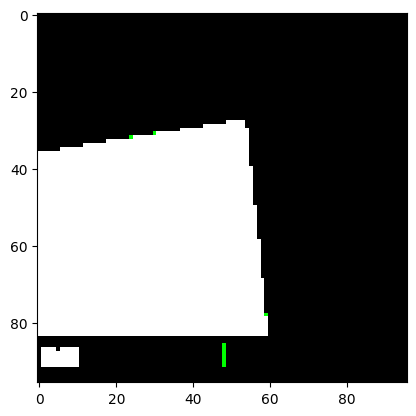

In [7]:
plt.imshow(state.numpy())

In [8]:
img = env.render()
img.shape

torch.Size([400, 600, 3])

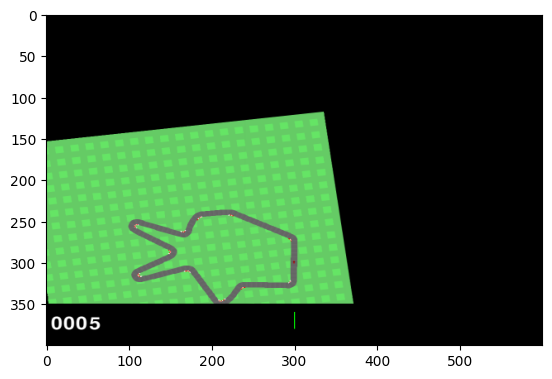

In [9]:
plt.imshow(img)

In [10]:
transposed_state = state.permute(2, 0, 1).to(T.float32)
transposed_state.shape, transposed_state.dtype

(torch.Size([3, 96, 96]), torch.float32)

In [11]:
class CarRacingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 8, 4),
            # nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 4, 2),
            # nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, 1),
            # nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # nn.Conv2d(256, 512, 3, 1),
            # nn.BatchNorm2d(512),
            nn.Flatten(),
            nn.Linear(4096, 512)
        )
        self.gru = nn.GRU(512, 256)
        self.action_mean_head = nn.Sequential(
            nn.Linear(256, 1024),
            # nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 3),
            nn.Tanh()
        )

        self.value_head = nn.Sequential(
            nn.Linear(256, 1024),
            # nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1),
        )
        
        self.log_std = nn.Parameter(T.full((3, ), -1., requires_grad=True))
    
    def forward(self, input: T.Tensor, hx: T.Tensor | None = None) -> Tuple[T.Tensor, T.Tensor, T.Tensor | None, Distribution]:
        if len(input.shape) == 3:
            input = input.unsqueeze(0)
        feature_map = self.conv(input)
        x, hx = self.gru(feature_map, hx)
        actor_mean = self.action_mean_head(x)
        std = self.log_std.clamp(-5, 2).exp()

        base_dist = Normal(loc=actor_mean, scale=std)
        dist = TransformedDistribution(
            base_dist,
            [
                TanhTransform(), 
                AffineTransform(
                    loc=T.tensor([0., 0.5, 0.5], dtype=T.float32, device=device),
                    scale=T.tensor([1., 0.5, 0.5], dtype=T.float32, device=device)
                )
            ]
        )
        action = dist.sample()

        value = self.value_head(x)
        return action, value, hx, base_dist

        

In [12]:
model = CarRacingModel().to(device)

In [13]:
action, value, hx, dist = model(transposed_state.to(device))
action.shape, value.shape, hx.shape, dist

(torch.Size([1, 3]),
 torch.Size([1, 1]),
 torch.Size([1, 256]),
 Normal(loc: torch.Size([1, 3]), scale: torch.Size([1, 3])))

In [14]:
def stack_buffer(replay_buffer: list):
    return (T.stack(col, dim=0) for col in zip(*replay_buffer))

In [ ]:
env = gym.make("CarRacing-v3", continuous=True, render_mode="rgb_array")
env = RecordVideo(env, "CarRacing_videos", lambda t: t % 50 == 0)
env = DtypeObservation(env, np.float32)
env = NumpyToTorch(env)

/opt/conda/lib/python3.11/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /app/rl_agents/notebooks/CarRacing_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [16]:
optimizer = Adam(model.parameters(), lr=2e-4)
gamma = 0.99
loss_fn = nn.HuberLoss()

In [17]:
def calculate_returns_and_advantages(rewards: T.Tensor, critic_values: T.Tensor, dones: T.Tensor, gamma_: float = 0.99, lambda_: float = 1.) -> Tuple[T.Tensor, T.Tensor]:
    # calculate returns and advantages
    returns, advantages = [], []
    g = T.tensor(0)
    for k in reversed(range(len(rewards)-1)):
        td_error = rewards[k] + gamma_ * critic_values[k + 1, 0] * (1 - dones[k]) - critic_values[k, 0]
        g = td_error + gamma_ * lambda_ * g * (1 - dones[k])
        
        returns.insert(0, g + critic_values[k, 0])
        advantages.insert(0, g)
    
    returns = T.stack(returns, dim=0)
    advantages = T.stack(advantages, dim=0)
    return returns, advantages

In [ ]:
NUM_EPOCHS = 1000
replay_buffer = []
i = 0

for epoch in range(NUM_EPOCHS):
    state, _ = env.reset()
    state = state.permute(2, 0, 1).to(T.float32).to(device)
    total_reward = 0
    done = False
    hx = T.zeros((1, 256), device=device)
    
    while not done:
        with T.no_grad():
            action, value, next_hx, _ = model(state, hx)
        action.squeeze_(0)
        
        next_state, reward, terminated, truncated, _ = env.step(action.cpu())
        done = terminated or truncated
        
        replay_buffer.append(
            (
                state,
                hx,
                action,
                value.squeeze(0),
                T.tensor([
                    reward
                    - 0.1 * action[0].abs().item() / (epoch + 1)
                    + 0.1 * action[1].item() / (epoch + 1)
                    - 0.1 * action[2].item() / (epoch + 1)
                ], dtype=T.float32, device=device),
                T.tensor([done], dtype=T.bool, device=device)
            )
        )
        
        state = next_state.permute(2, 0, 1).to(T.float32).to(device)
        hx = next_hx
        
        if i > 0 and i % 128 == 0:
            optimizer.zero_grad()
            # calculcate loss
            states, hxs, actions, state_values, rewards, dones = stack_buffer(replay_buffer)
            replay_buffer.clear()

            _, model_state_values, _, model_dist = model(states[:-1], hxs[0])
            
            returns, advantages = calculate_returns_and_advantages(
                rewards=rewards,
                critic_values=state_values,
                dones=dones.to(T.float32),
                gamma_=gamma,
                lambda_=1
            )
            
            advantages_to_actor = advantages.squeeze(-1).detach()
            advantages_to_actor = (advantages_to_actor - advantages_to_actor.mean()) / advantages_to_actor.std()
            
            actor_log_probs = model_dist.log_prob(actions[:-1])
            actor_loss = -(actor_log_probs.sum(-1) * advantages_to_actor).mean()
            
            critic_loss = loss_fn(state_values[:-1], returns)
            
            entropy = model_dist.entropy().mean()
            
            loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy
            loss.backward()
            # T.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()

        i += 1
        total_reward += reward
    print("Epoch", epoch, "reward", round(total_reward, 2), "i", i, "last action", action.cpu().numpy())
    print("Actor", round(actor_loss.item(), 4), "Critic", round(critic_loss.item(), 4), "Entropy", round(entropy.item(), 4))

        
        
    

Epoch 0 reward -31.15 i 1000 last action [0.85922766 0.8848903  0.8237799 ]
Actor 0.0727 Critic 5.5062 Entropy 0.4191
Epoch 1 reward -22.18 i 2000 last action [0.78299814 0.5146014  0.7027257 ]
Actor -0.1043 Critic 4.597 Entropy 0.4191
Epoch 2 reward -24.19 i 3000 last action [-0.08305737  0.80349874  0.56674814]
Actor -0.0555 Critic 3.9731 Entropy 0.4192
Epoch 3 reward -35.06 i 4000 last action [0.10533618 0.8698691  0.22850257]
Actor 0.1183 Critic 3.9322 Entropy 0.4193
Epoch 4 reward -39.6 i 5000 last action [0.77734935 0.88075763 0.14648074]
Actor 0.0385 Critic 3.9767 Entropy 0.4191
Epoch 5 reward -141.74 i 5943 last action [0.2253133  0.58361465 0.34258515]
Actor 0.048 Critic 3.9739 Entropy 0.419
Epoch 6 reward -25.49 i 6943 last action [0.39777884 0.8053105  0.37775886]
Actor 0.0527 Critic 3.8921 Entropy 0.419
Epoch 7 reward -26.06 i 7943 last action [-0.0257026   0.79277235  0.24650255]
Actor 0.0179 Critic 3.955 Entropy 0.4189
Epoch 8 reward -19.41 i 8943 last action [-0.756268  

KeyboardInterrupt: 